## Vincent's challenge or who is to get the LEGO

### Notes:

* https://en.wikipedia.org/wiki/Bayesian_information_criterion
* https://docs.pymc.io/notebooks/variational_api_quickstart.html

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
import numpy as np
import random
import requests as rq
import seaborn as sns
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from statistics import mean


np.random.seed(42)
pm.set_tt_rng(42)

In [ ]:
def get_distance(emb):
    # prepare request
    url = "http://challenge.calmcode.io/attempt/"

    # make request, remember to use your email!
    payload = {"user": "Filip Danieluk",
               "email": "filip.danieluk@cbre.com",
               "emb": emb}

    resp = rq.post(url, json=payload)

    # read response
    return resp.json()

In [ ]:
with pm.Model():
#     x = pm.Normal('x', mu=1.36, sigma=.9) # 114.2
#     x = pm.Cauchy('x', alpha=.95, beta=.14) # under 110
#     x = pm.Laplace('x', mu=.95, b=1e-8) # ~110
#     x = pm.StudentT('x', nu=15, mu=0.95, sigma=.1) # 106
    x = pm.StudentT('x', nu=2.6, mu=0.9, sigma=.1) # 106


#     x= pm.

In [ ]:
sns.distplot(x.random(size=100))

In [ ]:
emb = list(x.random(size=100))

In [ ]:
# emb = list(x.random(size=100))
get_distance(emb)

In [ ]:
def optimize(random_state=23):
    space = {'nu': hp.quniform('nu', 2, 3, .05),
             'mu': hp.quniform('mu', 0.2, 2, 0.1),
             'sigma': hp.quniform('sigma', 0.2, 3, 0.1)}

    best = fmin(score,
                space,
                algo=tpe.suggest, 
                max_evals=50)
    return best

In [ ]:
def score(params):
    with pm.Model():
        print(params)
        x = pm.StudentT('x', nu=params['nu'], mu=params['mu'], sigma=params['sigma'])
    emb = list(x.random(size=100))
    
    distances = []
    for i in range(0, 5):
        distances.append(get_distance(emb)['distance'])
    loss = min(distances)
    print(loss, distances)
    print('\n')
    return {'loss': loss, 'status': STATUS_OK}

In [ ]:
def score(params):
    with pm.Model():
        print(params)
        x = pm.StudentT('x', nu=params['nu'], mu=params['mu'], sigma=params['sigma'])
    emb = list(x.random(size=100))
    
    distances = []
    for i in range(0, 5):
        distances.append(get_distance(emb)['distance'])
    loss = min(distances)
    print(loss, distances)
    print('\n')
    return {'loss': loss, 'status': STATUS_OK}

In [ ]:
optimize()

# Parsing JSONs

In [4]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import json
from tqdm import tqdm
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt

pd.set_option('max_rows', 10000)

In [5]:
raw_path = Path('data/raw')
processed_path = Path('data/processed')

files = list(raw_path.glob('*.json'))

In [6]:
files

[WindowsPath('data/raw/data_dump.json'),
 WindowsPath('data/raw/data_dump_afternoon.json'),
 WindowsPath('data/raw/data_dump_afternoon2.json'),
 WindowsPath('data/raw/data_dump_old.json'),
 WindowsPath('data/raw/data_dump_play.json'),
 WindowsPath('data/raw/data_dump_playground.json'),
 WindowsPath('data/raw/data_dump_thu_midday.json')]

In [563]:
# jsons = []
# for file in tqdm(files):
#     with open(file) as f:
#         jsons.append(json.load(f))
# df = pd.DataFrame(jsons)

In [7]:
def please_parse_my_fuckedup_json(file_path):
    from json import JSONDecoder, JSONDecodeError
    import re

    NOT_WHITESPACE = re.compile(r'[^\s]')

    def decode_stacked(document, pos=0, decoder=JSONDecoder()):
        while True:
            match = NOT_WHITESPACE.search(document, pos)
            if not match:
                return
            pos = match.start()

            try:
                obj, pos = decoder.raw_decode(document, pos)
            except JSONDecodeError:
                continue
                # do something sensible if there's some error
                raise
            yield obj

    jsons = []
    with open(file_path) as f:
        for obj in decode_stacked(f.read()):
            jsons.append(obj)
            
    df = pd.DataFrame(jsons)    
    return df

In [91]:
df = please_parse_my_fuckedup_json('data/raw/data_dump_1592575948.9524539.json')

In [92]:
df.describe()

,distance
count,155739.000000
mean,46.925208
std,9.425951
min,24.624108
25%,39.730074
50%,46.312965
75%,52.915110
max,91.481955


In [93]:
df['emb_id'] = df.emb.astype(str).apply(hash)

In [73]:
# df.to_parquet('hyperopt_simple7_18062020.parquet')

In [74]:
# df = pd.read_parquet(processed_path / 'hyperopt_simple5_18062020.parquet')

In [96]:
temp = df.sort_values('distance').drop_duplicates('emb_id', keep='first').head(4)

temp

,user,email,emb,distance,datetime,id,emb_id
118260,Filip Danieluk,filip.danieluk@cbre.com,"[-2.7160648170116057, 0.10526776086198984, 8.2...",24.624108,2020-06-19 11:32:45.443736,f7d10dda-b223-4d9b-803c-861027055b9e,7902992874814115605
134479,Filip Danieluk,filip.danieluk@cbre.com,"[-3.09336230044805, 0.12876577910779397, 7.607...",24.779016,2020-06-19 11:44:01.218447,88195646-3f4a-4ea3-b053-43023c1a14dd,-2847339242285568844
136489,Filip Danieluk,filip.danieluk@cbre.com,"[-3.1272670429164373, 0.16893772928758416, 7.7...",24.892985,2020-06-19 11:45:23.013040,ee711012-9e2a-4964-97be-53b8591da9ba,5918581370236527818
114510,Filip Danieluk,filip.danieluk@cbre.com,"[-2.7669743156425057, 0.014257008874965768, 8....",24.940834,2020-06-19 11:30:12.361457,fd467df9-1c50-43f0-9547-3deafcebcb4f,-2458394802165413351


In [59]:
df2 = df.loc[df.emb_id == temp.loc[162691,'emb_id'],:]

KeyError: 162691

In [516]:
df2.sort_values('distance').hea()

,user,email,emb,distance,datetime,id,emb_id
162691,Filip Danieluk,filip.danieluk@cbre.com,"[-0.35697675523526334, -0.01749939004669693, 7...",59.165270,2020-06-18 16:03:53.160653,10c3dbdf-fee2-44d9-8120-50540fd3c23c,-302829899230002782
164906,Filip Danieluk,filip.danieluk@cbre.com,"[-0.35697675523526334, -0.01749939004669693, 7...",62.901087,2020-06-18 16:05:21.190497,31fbab79-5e56-40aa-ae06-7f4c291be394,-302829899230002782
162419,Filip Danieluk,filip.danieluk@cbre.com,"[-0.35697675523526334, -0.01749939004669693, 7...",65.645336,2020-06-18 16:03:42.263669,a9761fda-2b1a-4a9e-84f8-08f84dab19be,-302829899230002782
165045,Filip Danieluk,filip.danieluk@cbre.com,"[-0.35697675523526334, -0.01749939004669693, 7...",65.807662,2020-06-18 16:05:26.740358,3b6dd8da-e60a-488e-8cc0-fe7443ace601,-302829899230002782
162494,Filip Danieluk,filip.danieluk@cbre.com,"[-0.35697675523526334, -0.01749939004669693, 7...",65.811452,2020-06-18 16:03:45.267284,13f3486e-b4e0-4d82-a7ff-2ab5a4121ec9,-302829899230002782
162493,Filip Danieluk,filip.danieluk@cbre.com,"[-0.35697675523526334, -0.01749939004669693, 7...",65.880119,2020-06-18 16:03:45.226846,9cf87354-db39-4e0e-bfc0-7aeb96e6c821,-302829899230002782
162499,Filip Danieluk,filip.danieluk@cbre.com,"[-0.35697675523526334, -0.01749939004669693, 7...",66.158724,2020-06-18 16:03:45.462613,3935f2ed-a38d-476d-a6c4-64c634a8d5d1,-302829899230002782
162608,Filip Danieluk,filip.danieluk@cbre.com,"[-0.35697675523526334, -0.01749939004669693, 7...",66.190067,2020-06-18 16:03:49.822652,e979bb19-32a6-484f-bc76-691314bfc082,-302829899230002782
162546,Filip Danieluk,filip.danieluk@cbre.com,"[-0.35697675523526334, -0.01749939004669693, 7...",66.203414,2020-06-18 16:03:47.360104,aba1f6a2-6c57-4bac-92a4-3eaf99b081bb,-302829899230002782
162424,Filip Danieluk,filip.danieluk@cbre.com,"[-0.35697675523526334, -0.01749939004669693, 7...",66.284099,2020-06-18 16:03:42.472629,8b67ad85-7687-4a97-b940-3ad549c747a3,-302829899230002782


In [427]:
# best_v = []
# for show in temp.iterrows():
#     sns.lineplot(x=range(100), y=show[1]['emb'])
#     best_v.append(show[1]['emb'])

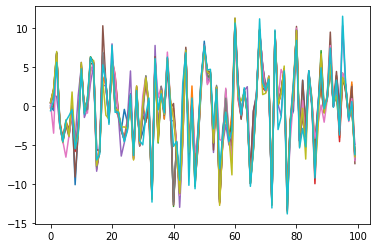

In [180]:
# best_v = []
# for show in temp.iterrows():
#     sns.lineplot(x=range(100), y=show[1]['emb'])
#     best_v.append(show[1]['emb'])

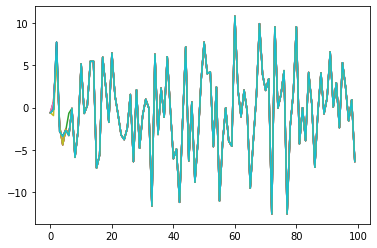

In [208]:
best_v = []
for show in temp.iterrows():
    sns.lineplot(x=range(100), y=show[1]['emb'])
    best_v.append(show[1]['emb'])

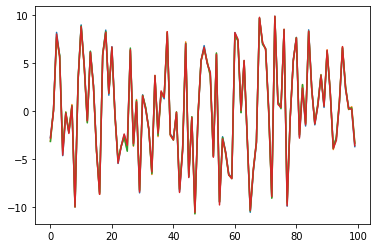

In [97]:
best_v = []
for show in temp.iterrows():
    sns.lineplot(x=range(100), y=show[1]['emb'])
    best_v.append(show[1]['emb'])

In [98]:
mean_vector = np.mean(np.array(best_v), axis=0)

In [99]:
mean_vector

array([ -2.92591712,   0.10430707,   7.91638512,   5.77455177,
        -4.33878822,  -0.14618958,  -2.18440794,   0.59964074,
        -9.93470577,   3.2856607 ,   8.89438428,   4.73188562,
        -1.05398829,   6.21786923,   2.66259699,  -4.12366102,
        -8.56851206,   5.90244994,   8.32513394,   1.85173262,
         6.63299123,  -0.38769569,  -5.22694104,  -3.64179867,
        -2.52412888,  -3.81289046,   6.43500955,  -3.45690098,
         1.08675078,  -8.32170023,   1.66997177,   0.30163379,
        -1.84988529,  -6.42522649,   3.70392029,  -2.39693782,
         1.98977755,   1.46874173,   8.25352094,  -2.43083541,
        -2.91337546,  -0.11664101,  -8.24668035,  -3.96616587,
         7.11498323,  -6.776439  ,  -0.60890586, -10.52835629,
        -0.44917007,   5.2864028 ,   6.64425776,   5.08779726,
         3.88472353,  -4.69346496,   5.99482694,  -9.50208289,
        -2.74393186,  -4.31508455,  -6.57199462,  -6.96878609,
         8.06797348,   7.40507447,  -0.0434593 ,   5.26

In [200]:
#     sns.lineplot(x=range(100), y=mean_vector)


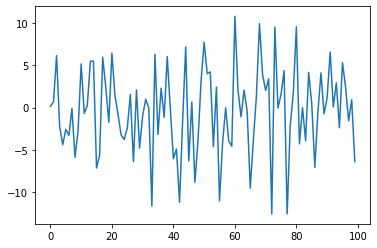

In [184]:
# sns.lineplot(x=range(100), y=mean_vector)


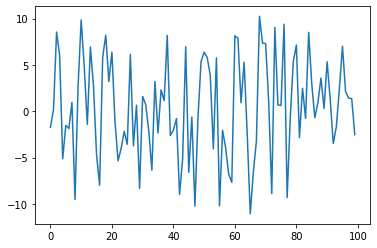

In [46]:
sns.lineplot(x=range(100), y=mean_vector)


In [25]:
evol_vec = [-0.23154959228255922, -0.029344924285608198, 7.879901251206385, 5.406904177621347, -4.785041806002869, -2.372650033237262, -3.5254330081971283, 0.6278072752735018, -9.271890881326653, 2.0969305493186967, 9.95369000411877, 4.264926972769839, -0.2600662210873568, 6.87575396560945, 2.8573536889767572, -4.885935369056868, -7.4499276988989305, 5.722146197815027, 8.186977734912439, 2.807875966699653, 6.937736559635362, -1.8871019001927283, -5.055025884010282, -1.8968404260951899, -1.784834947865023, -4.471460399113214, 5.039113660174237, -3.376021977617031, 0.5473306878453228, -8.459927571913896, 1.7715313486097761, 1.7042201620007684, -1.9746282309898167, -6.837211460104226, 4.058560727149436, -2.5061773934186586, 1.6220541549553484, 0.6037096373716307, 8.629363953301809, -2.243937007410063, -0.19814699953800696, -0.44405671319433937, -7.426440524373838, -3.805540200475637, 8.085535736155506, -7.968637716341345, -0.015579610442543745, -10.216527335412575, -1.4824741472324907, 2.699992980074362, 7.390644004309081, 4.88668408959332, 4.3035409869543555, -4.478428221302762, 4.306488353808031, -9.317202100421442, -0.9590053622572191, -4.041970947938315, -6.110357058172626, -7.179985393623797, 7.5046375879088405, 7.692371986404354, 0.04835676806475553, 4.959027980405287, -2.2259289765114465, -11.62942639942954, -6.068641106135216, -3.75147018129194, 9.598612500439252, 5.4309546031438884, 7.171581816306619, 0.6112151332211039, -9.314114149573872, 7.626947839968836, 1.6317324270791829, -1.2195879648218484, 8.781336038211016, -9.061401397250561, 0.24086581891827524, 4.644391474424802, 6.251297970403646, -2.7326763977188184, 2.415572164463519, -1.8217732510032518, 7.559925989596271, 2.034914873661892, -1.206379628528763, 0.6581418985157745, 3.267419698092879, -0.005776213547322939, 4.601806103988456, 2.1852371030691295, -3.3522244250423228, -0.981705690082751, 1.7665103984109924, 7.448303135963404, 0.8366714725390045, 0.4836567507919033, 2.07695381129683, -1.3851402152251708]

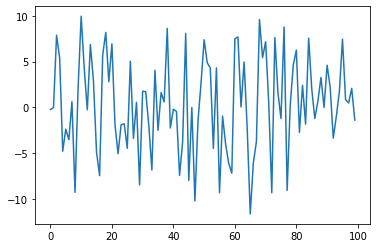

In [26]:
sns.lineplot(x=range(100), y=evol_vec)


# Krzysiek

In [518]:
# df = pd.read_parquet(processed_path / 'hyperopt_simple5_18062020.parquet')
df_playground = please_parse_my_fuckedup_json('data/raw/data_dump_play.json')
df_playground.sort_values('datetime')
df_playground['emb_id'] = df_playground.emb.astype(str).apply(hash)

df_playground['distance_log'] = np.log10(df.distance)
temp_playground = df_playground.sort_values('datetime').drop_duplicates('emb_id', keep='first').head(25)

temp_playground.tail()

,user,email,emb,distance,datetime,id,emb_id,distance_log
0,Filip Danieluk,filip.danieluk@cbre.com,"[10000, 10000, 10000, 10000, 10000, 10000, 100...",2.199794e+05,2020-06-18 14:20:39.179442,0ebba491-576d-435c-9641-7237b71dd485,-8206584530969749496,1.894323
1000,Filip Danieluk,filip.danieluk@cbre.com,"[100000, 100000, 100000, 100000, 100000, 10000...",2.200000e+06,2020-06-18 14:23:53.008138,2f8afbdc-075a-4328-94ba-7d086071cb18,5433631016346864158,1.879297
2000,Filip Danieluk,filip.danieluk@cbre.com,"[100, 100, 100, 100, 100, 100, 100, 100, 100, ...",2.184896e+03,2020-06-18 14:34:59.444577,c7cc53e4-e07c-44ab-8d89-4ae469f44f4f,3139554466493753786,1.896221
3000,Filip Danieluk,filip.danieluk@cbre.com,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.237926e+02,2020-06-18 14:37:53.339264,e49e0f8f-e6a3-47fa-be76-ad38b11f27d5,8070843640783419644,1.919711


In [522]:
temp_playground_zeroes = df_playground[df_playground['emb_id'] == 8070843640783419644]

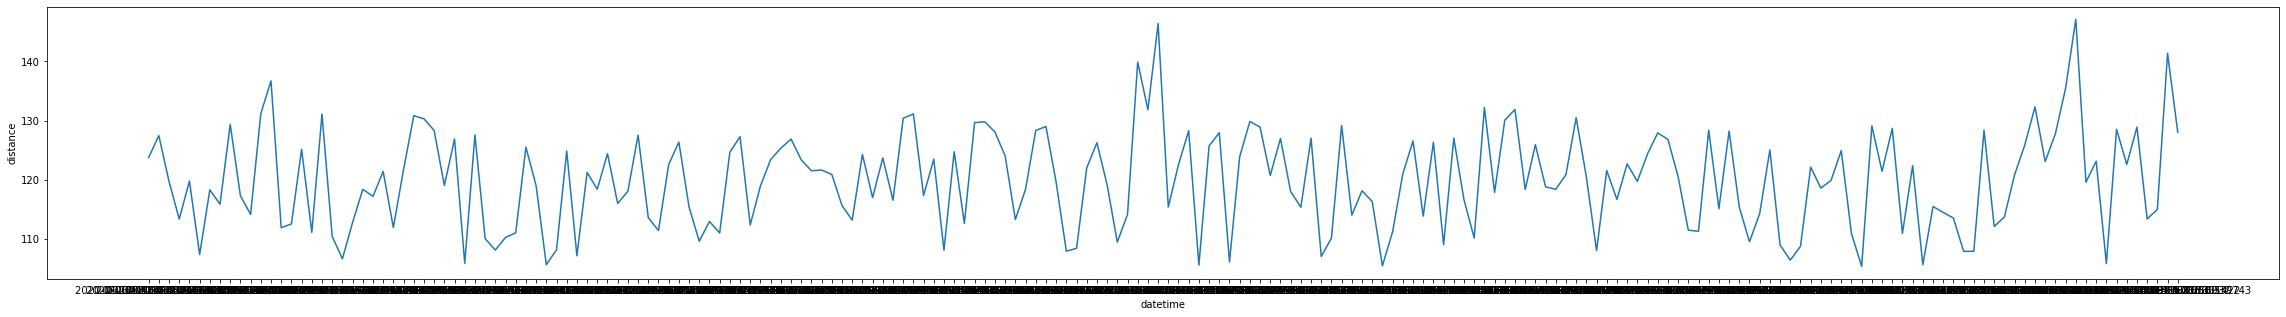

In [559]:
temp_playground_zeroes.describe()
df2.describe()
plt.figure(figsize=(40,5))

datetimes_plot = temp_playground_zeroes.datetime[0:200]
zeroess_plot = temp_playground_zeroes.distance[0:200]

sns.lineplot(x=datetimes_plot, y=zeroess_plot)

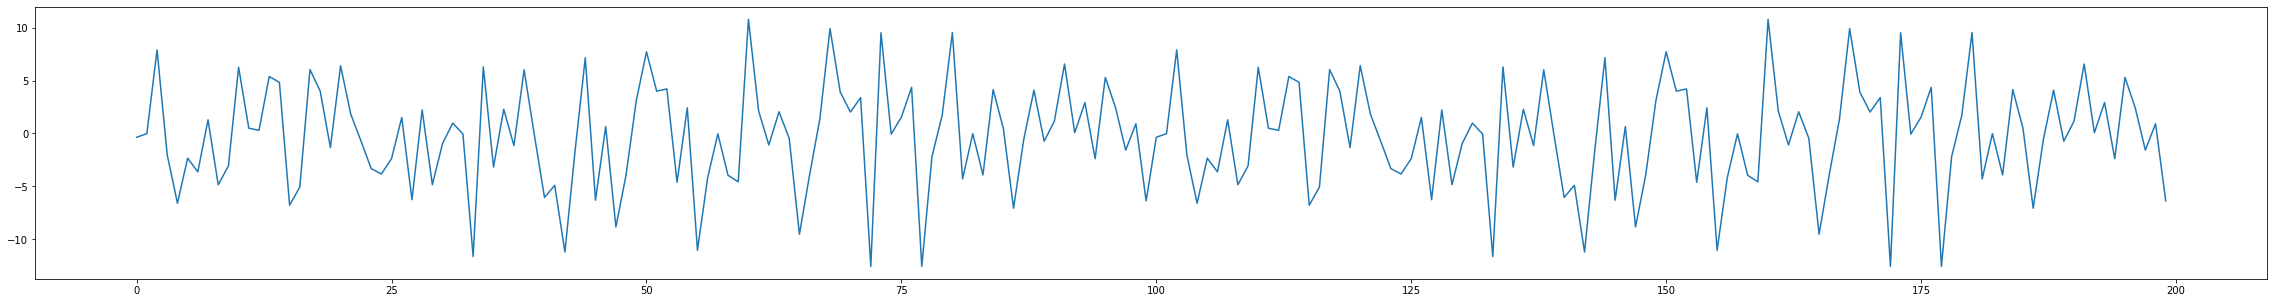

In [560]:
a = df[df.emb_id == -302829899230002782]
emb_times_10 = (a.iloc[1, 2] * 10)[0:200]
index_for_plot = list(range(1000))[0:200]

plt.figure(figsize=(40,5))
sns.lineplot(index_for_plot, emb_times_10)

## Additional analysis

In [482]:
# df = pd.read_parquet(processed_path / 'hyperopt_simple5_18062020.parquet')
df = please_parse_my_fuckedup_json('data/raw/data_dump_play.json')
df.sort_values('datetime')
df['emb_id'] = df.emb.astype(str).apply(hash)

df['distance_log'] = np.log10(df.distance)

In [483]:
df.emb_id.value_counts()

 5433631016346864158    1000
 8070843640783419644    1000
-8206584530969749496    1000
 3139554466493753786    1000
Name: emb_id, dtype: int64

In [484]:
temp = df.sort_values('datetime').drop_duplicates('emb_id', keep='first').head(25)

temp.tail()

,user,email,emb,distance,datetime,id,emb_id,distance_log
0,Filip Danieluk,filip.danieluk@cbre.com,"[10000, 10000, 10000, 10000, 10000, 10000, 100...",2.199794e+05,2020-06-18 14:20:39.179442,0ebba491-576d-435c-9641-7237b71dd485,-8206584530969749496,5.342382
1000,Filip Danieluk,filip.danieluk@cbre.com,"[100000, 100000, 100000, 100000, 100000, 10000...",2.200000e+06,2020-06-18 14:23:53.008138,2f8afbdc-075a-4328-94ba-7d086071cb18,5433631016346864158,6.342423
2000,Filip Danieluk,filip.danieluk@cbre.com,"[100, 100, 100, 100, 100, 100, 100, 100, 100, ...",2.184896e+03,2020-06-18 14:34:59.444577,c7cc53e4-e07c-44ab-8d89-4ae469f44f4f,3139554466493753786,3.339431
3000,Filip Danieluk,filip.danieluk@cbre.com,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.237926e+02,2020-06-18 14:37:53.339264,e49e0f8f-e6a3-47fa-be76-ad38b11f27d5,8070843640783419644,2.092695


In [469]:
a = df[df.emb_id == 8206584530969749496]
a = a.sort_values('datetime')

In [470]:
len(a)

1000

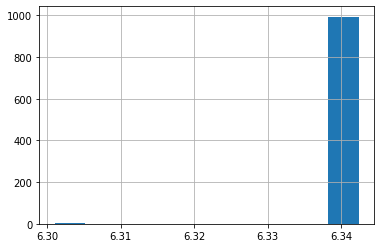

In [472]:
a.distance_log.hist()

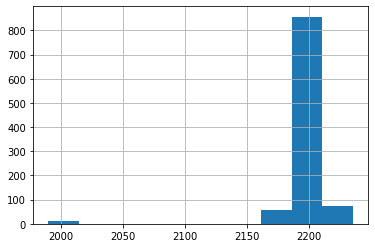

In [397]:
a.distance.hist()

# wektor dystansow dla najlepszego emb

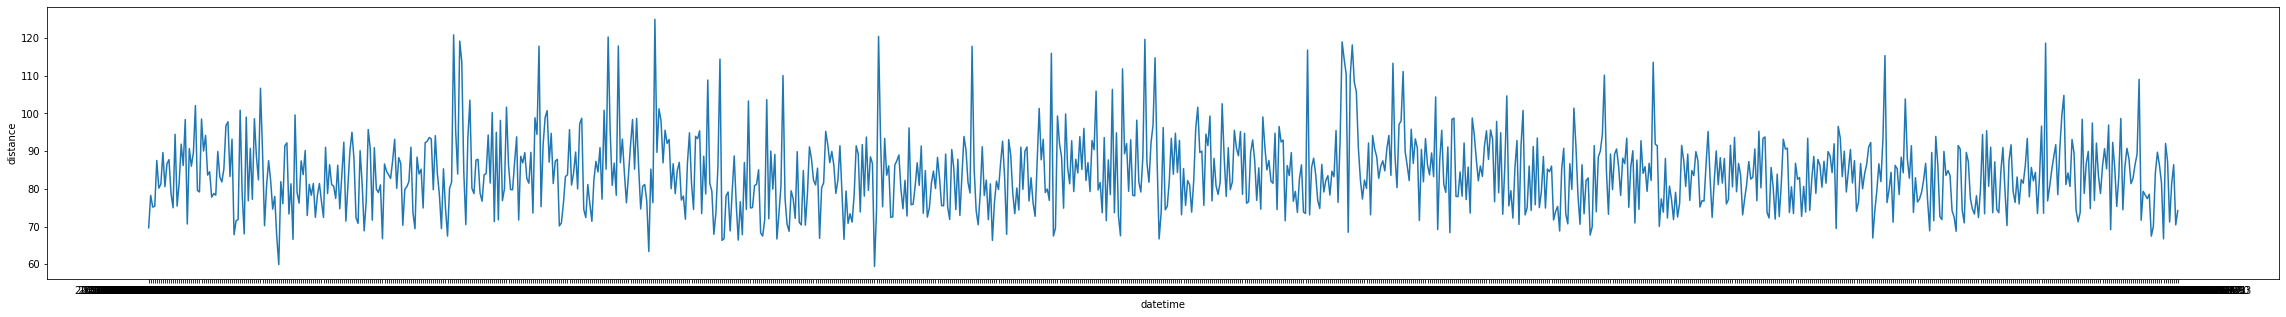

In [440]:
plt.figure(figsize=(40,5))
sns.lineplot(x=a.datetime, y=a.distance)

# wektor 100_000

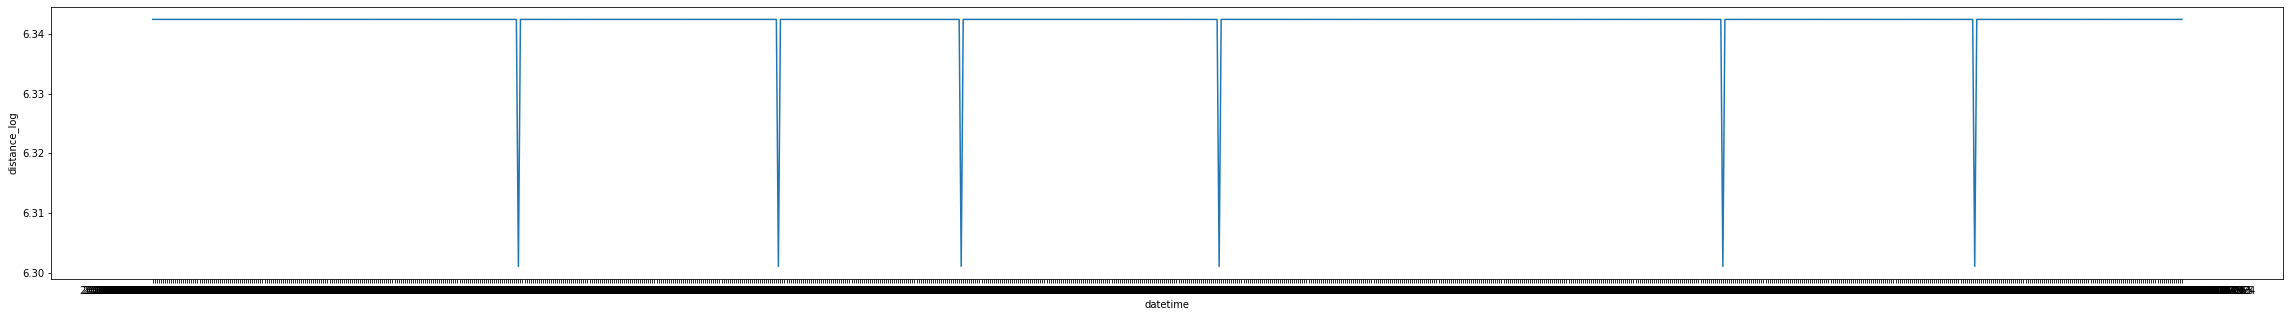

In [474]:
a = df[df.emb_id == 5433631016346864158]
a = a.sort_values('datetime')

plt.figure(figsize=(40,5))
sns.lineplot(x=a.datetime, y=a.distance_log)

# wektor 10_000

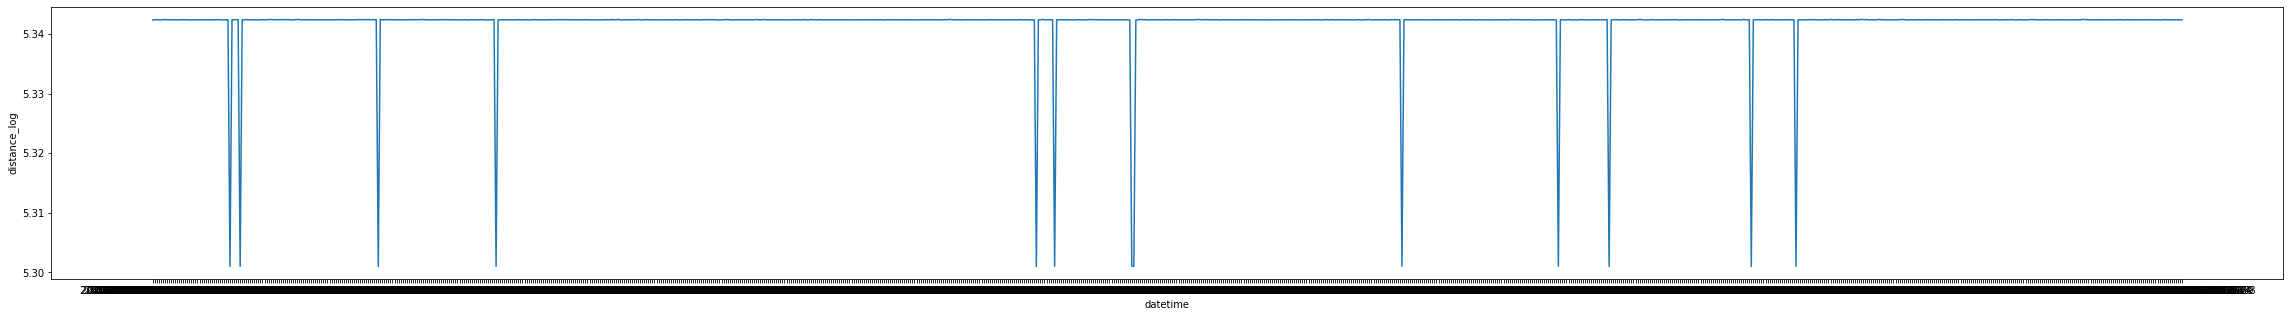

In [475]:
a = df[df.emb_id == -8206584530969749496]
a = a.sort_values('datetime')

plt.figure(figsize=(40,5))
sns.lineplot(x=a.datetime, y=a.distance_log)

# wektor samych 100

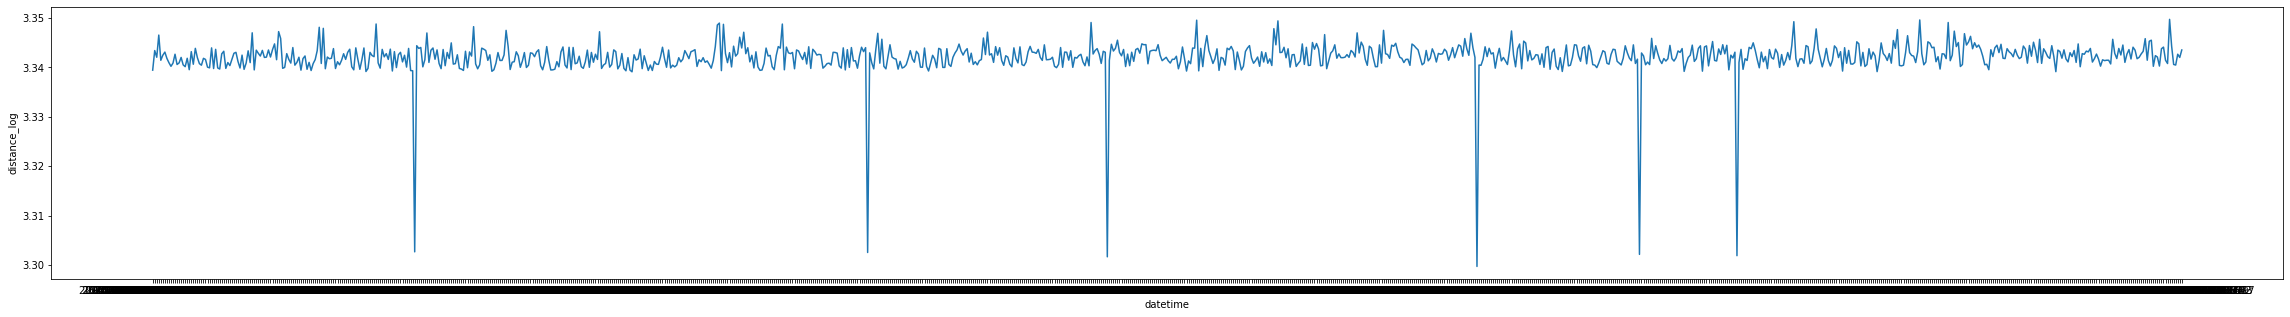

In [481]:
a = df[df.emb_id == 3139554466493753786]
a = a.sort_values('datetime')

plt.figure(figsize=(40,5))
sns.lineplot(x=a.datetime, y=a.distance_log)

# wektor samych 0

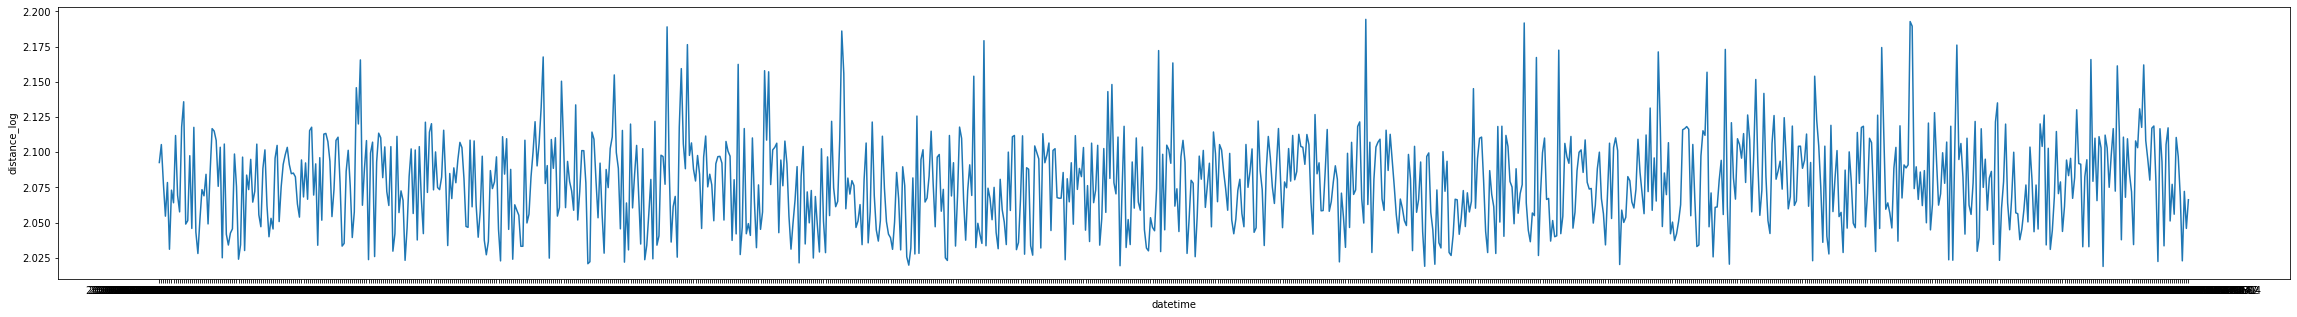

In [485]:
a = df[df.emb_id == 8070843640783419644]
a = a.sort_values('datetime')

plt.figure(figsize=(40,5))
sns.lineplot(x=a.datetime, y=a.distance_log)

# wektor ~150 tek

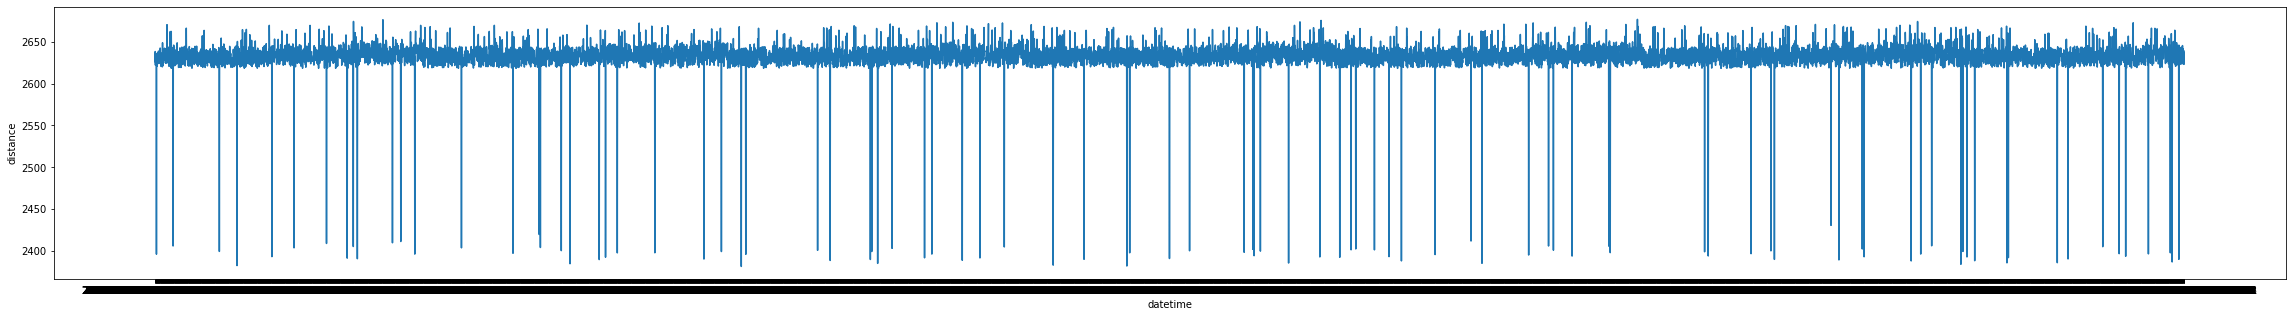

In [382]:
plt.figure(figsize=(40,5))
sns.lineplot(x=a.datetime, y=a.distance)

# wektor samych 50

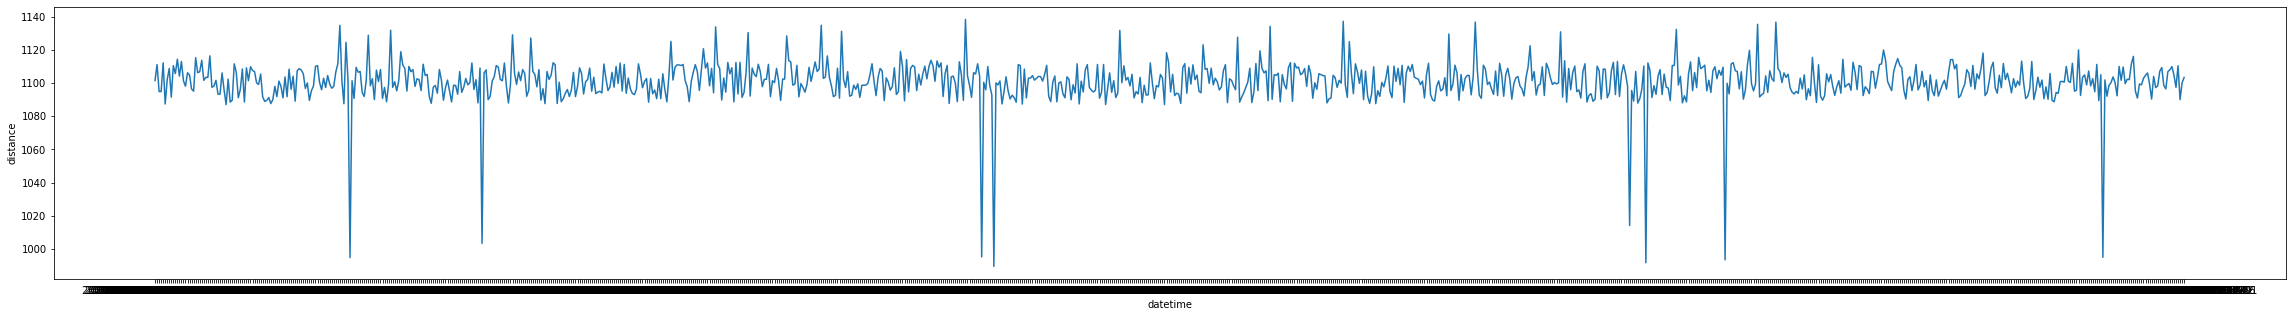

In [405]:
plt.figure(figsize=(40,5))
sns.lineplot(x=a.datetime, y=a.distance)

# wektor samych -50

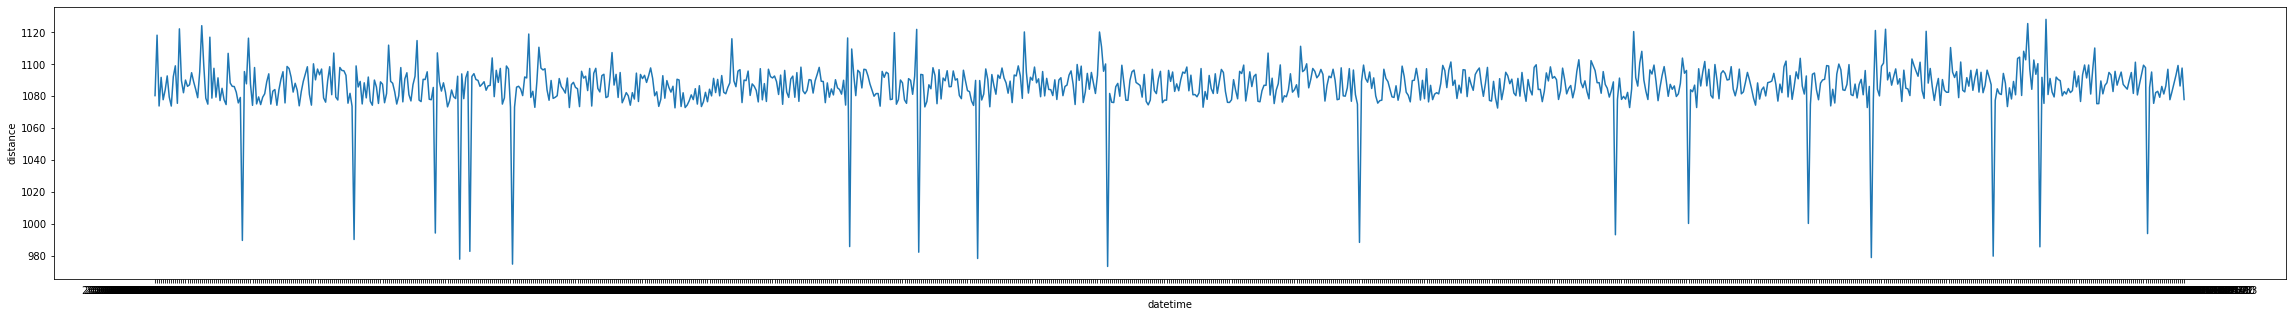

In [420]:
plt.figure(figsize=(40,5))
sns.lineplot(x=a.datetime, y=a.distance)

# wektor samych 10

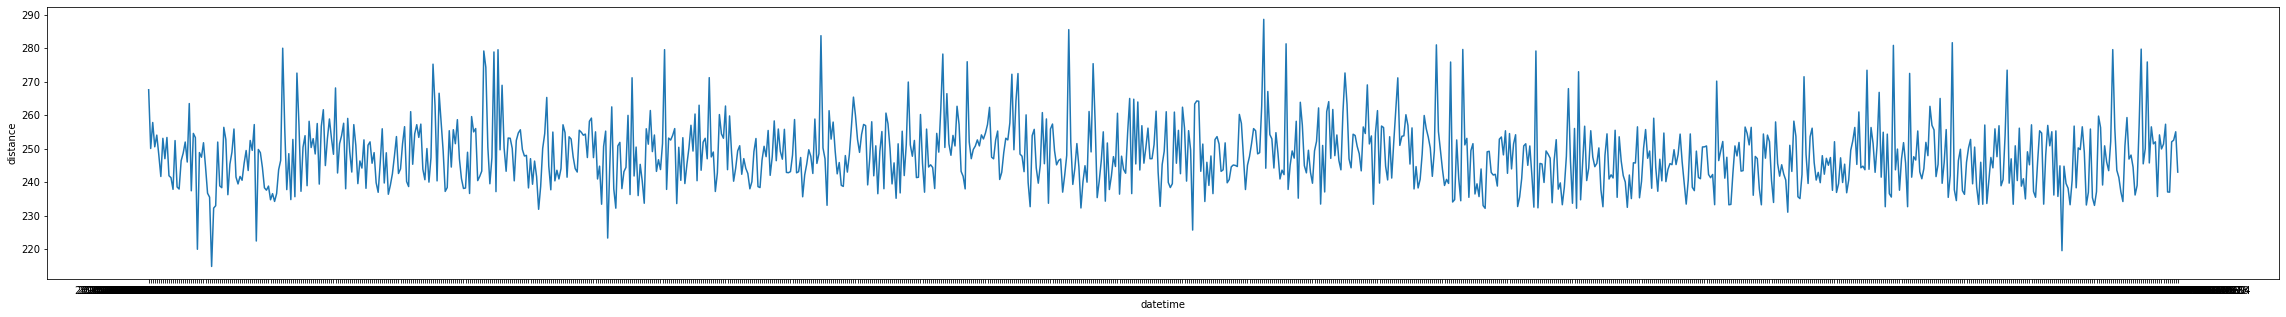

In [412]:
plt.figure(figsize=(40,5))
sns.lineplot(x=a.datetime, y=a.distance)

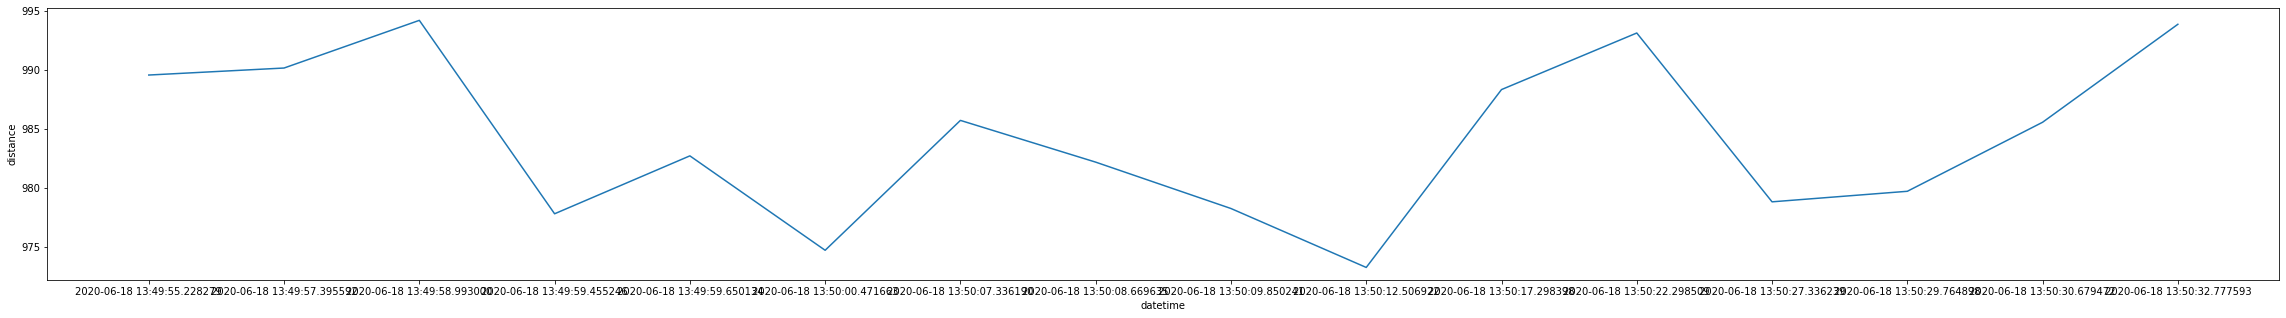

In [423]:
plt.figure(figsize=(40,5))
sns.lineplot(x=a[a.distance < 2450].datetime, y=a[a.distance < 1000].distance)

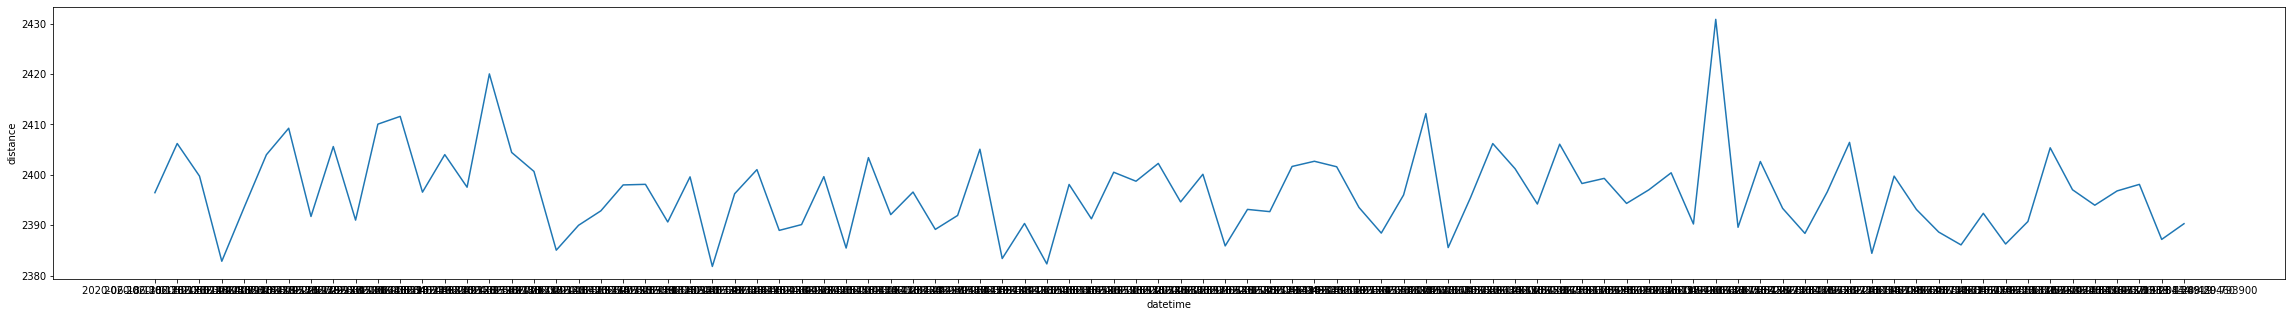

In [383]:
plt.figure(figsize=(40,5))
sns.lineplot(x=a[a.distance < 2450].datetime, y=a[a.distance < 2450].distance)

from 13:01:51.776857 to 13:08:30.821832

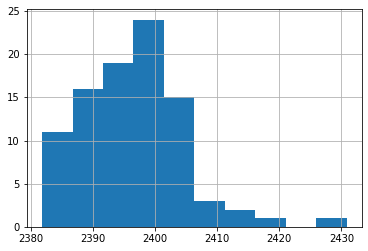

In [391]:
a[a.distance < 2450].distance.hist()

In [422]:
a[a.distance < 1020]

,user,email,emb,distance,datetime,id,emb_id
24934,Filip Danieluk,filip.danieluk@cbre.com,"[-50, -50, -50, -50, -50, -50, -50, -50, -50, ...",989.566938,2020-06-18 13:49:55.228279,3d20f86b-f85c-4f85-88e4-7bc69c3ad822,-5585844858729754497
24989,Filip Danieluk,filip.danieluk@cbre.com,"[-50, -50, -50, -50, -50, -50, -50, -50, -50, ...",990.161056,2020-06-18 13:49:57.395592,1e50b6f1-4e06-47dd-ba62-da72ddd2482a,-5585844858729754497
25029,Filip Danieluk,filip.danieluk@cbre.com,"[-50, -50, -50, -50, -50, -50, -50, -50, -50, ...",994.202827,2020-06-18 13:49:58.993000,0f7e1811-08be-4d8b-8654-15c013b7a3ab,-5585844858729754497
25041,Filip Danieluk,filip.danieluk@cbre.com,"[-50, -50, -50, -50, -50, -50, -50, -50, -50, ...",977.803554,2020-06-18 13:49:59.455246,af78a25a-2908-4406-b56a-fed50ac06764,-5585844858729754497
25046,Filip Danieluk,filip.danieluk@cbre.com,"[-50, -50, -50, -50, -50, -50, -50, -50, -50, ...",982.713528,2020-06-18 13:49:59.650134,a0bfb978-da63-4087-a3cd-48079f3fd076,-5585844858729754497
25067,Filip Danieluk,filip.danieluk@cbre.com,"[-50, -50, -50, -50, -50, -50, -50, -50, -50, ...",974.709110,2020-06-18 13:50:00.471663,6b040a0e-8c29-4006-b5c4-cae823df791c,-5585844858729754497
25233,Filip Danieluk,filip.danieluk@cbre.com,"[-50, -50, -50, -50, -50, -50, -50, -50, -50, ...",985.720732,2020-06-18 13:50:07.336190,a07ef6f2-d510-49e9-916d-ae5fa0989c08,-5585844858729754497
25267,Filip Danieluk,filip.danieluk@cbre.com,"[-50, -50, -50, -50, -50, -50, -50, -50, -50, ...",982.182040,2020-06-18 13:50:08.669635,ab029936-4734-413b-a481-62b337772d94,-5585844858729754497
25296,Filip Danieluk,filip.danieluk@cbre.com,"[-50, -50, -50, -50, -50, -50, -50, -50, -50, ...",978.250529,2020-06-18 13:50:09.850241,18a4b4bb-2413-44d4-a7c1-a104962e3d9a,-5585844858729754497
25360,Filip Danieluk,filip.danieluk@cbre.com,"[-50, -50, -50, -50, -50, -50, -50, -50, -50, ...",973.253430,2020-06-18 13:50:12.506922,9764e731-26d0-49da-bfdb-2f80fcbbf4f5,-5585844858729754497
